# Chapter 4. The Effects of Feature Scaling: From Bag-of-Words to Tf-Idf

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as preproc

## Example 4-1. Loading and cleaning the Yelp reviews dataset in Python

In [2]:
## Yelp 비즈니스 데이터 로드
biz_f = open('data/yelp/yelp_academic_dataset_business.json', encoding='utf-8')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()

## Yelp 리뷰 데이터 로드
review_file = open('data/yelp/yelp_academic_dataset_review.json', encoding='utf-8')
review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])
review_file.close()

In [3]:
biz_df.shape

(188593, 15)

In [4]:
review_df.shape

(5996996, 9)

In [5]:
biz_df[['business_id','categories','name','stars']].head()

,business_id,categories,name,stars
0,Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Minhas Micro Brewery,4.0
1,AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",CK'S BBQ & Catering,4.5
2,O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",La Bastringue,4.0
3,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Geico Insurance,1.5
4,8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Action Engine,2.0


In [6]:
type(biz_df.categories)

pandas.core.series.Series

In [7]:
# categories == None인 데이터 제거
nan_idx = biz_df.loc[biz_df.categories.isnull()].index

biz_df.drop(biz_df.index[[nan_idx]], inplace=True)
biz_df.shape

(188052, 15)

In [8]:
# Nightlife 또는 Restaurants 비즈니스만 추출
two_biz = biz_df[biz_df.apply(lambda x: 'Nightlife' in x['categories'] or 'Restaurants' in x['categories'], axis=1)]
two_biz.shape

(61663, 15)

In [9]:
# 비즈니스 데이터와 리뷰 데이터를 하나로 통합
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')
twobiz_reviews.shape

(3824964, 23)

In [10]:
# 추출한 데이터를 파일로 저장
twobiz_reviews.to_pickle('data/yelp/twobiz_reviews.pkl')

In [11]:
# 저장한 파일 다시 불러오기
twobiz_reviews = pd.read_pickle('data/yelp/twobiz_reviews.pkl')
twobiz_reviews.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,stars_x,state,cool,date,funny,review_id,stars_y,text,useful,user_id
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,...,4.0,AB,0,2014-08-21,0,twCy6q-VJ2wunPzLHysHBg,4,Great place. Major flaw is how early it closes...,0,sKexIMFNAlFeuXl2KW6rjw
1,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,...,4.0,AB,0,2015-06-15,0,5fb4JYLFtZ-b3EdRaAPmTQ,5,The best fresh pizza and selection of micro br...,0,ebActGRuC2wr4GeqRstRJQ
2,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,...,4.0,AB,0,2017-06-17,0,CHm6DMhPFSM9EU8uDlpWbQ,3,Bought the Groupon for four people and pizza. ...,0,TakhclDII1B1q5qfdWLIWQ


In [12]:
# 사용하지 않는 피쳐 제거. 즉, 사용할 피쳐만 지정
twobiz_reviews = twobiz_reviews[['business_id', 
                                 'name', 
                                 'stars_y', 
                                 'text', 
                                 'categories']]
twobiz_reviews.shape

(3824964, 5)

In [13]:
# target 컬럼 생성. Nightlife 비즈니스이면 True, 아니면 False로 값 설정.
# categories에 두 클래스가 모두 존재하는 경우에는 True (Nightlife) 로 설정됨.

twobiz_reviews['target'] = twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)

## Example 4-2. Creating a balanced classification dataset

In [14]:
# 모델에 사용하기 위해 클래스 균형을 맞춘 샘플링 데이터 생성 (원서 코드)
# nightlife = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)]
# restaurants = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Restaurants' in x['categories'], axis=1)]

In [15]:
# 모델에 사용하기 위해 클래스 균형을 맞춘 샘플링 데이터 생성 - 위 코드보다 속도 빠름.
# target : Nightlife = True / Restaurants = False

nightlife = twobiz_reviews[twobiz_reviews.target == True]
restaurants = twobiz_reviews[twobiz_reviews.target == False]

In [16]:
nightlife.shape

(1005229, 6)

In [17]:
restaurants.shape

(2819735, 6)

In [18]:
# 두 클래스의 샘플 수가 대략적으로 비슷하도록 퍼센트(frac)를 선택한다.
nightlife_subset = nightlife.sample(frac=0.03, random_state=123)
restaurant_subset = restaurants.sample(frac=0.011, random_state=123)
print('nightlife:', nightlife_subset.shape)
print('restaurant:', restaurant_subset.shape)

nightlife: (30157, 6)
restaurant: (31017, 6)


In [19]:
# 추출한 데이터 저장
nightlife_subset.to_pickle('data/yelp/nightlife_subset.pkl')
restaurant_subset.to_pickle('data/yelp/restaurant_subset.pkl')

In [20]:
# 두 클래스의 데이터 합치기
combined = pd.concat([nightlife_subset, restaurant_subset])

In [21]:
print('nightlife:', combined[combined.target == True].shape)
print('restaurant:', combined[combined.target == False].shape)

nightlife: (30157, 6)
restaurant: (31017, 6)


In [22]:
combined.head()

,business_id,name,stars_y,text,categories,target
3577993,e9sB72njxz87r5TL6kG-Fw,Cowbell Burger & Whiskey Bar,4,I've been here a couple of times int he last 2...,"Whiskey Bars, Burgers, Bars, Nightlife, Restau...",True
3708383,wkKlpSx3OcoGJiv7p8VZzw,Sparrow + Wolf,2,"This place is definitely attractive, their coc...","Restaurants, Cocktail Bars, Bars, American (Ne...",True
1618527,g6QPEH9DcbxrQjZAckNMkA,Hickory Tavern,1,I have never left a negative rating about a pl...,"Nightlife, Sports Bars, Chicken Wings, Bars, R...",True
3329865,2iTsRqUsPGRH1li1WVRvKQ,Carson Kitchen,5,This place has quickly become one of my favori...,"American (New), Restaurants, Salad, Burgers, F...",True
924248,aNe8ofTYrealxqv7VtFTuw,Sierra Gold,5,This is obviously one of my regular hangouts. ...,"Breweries, American (New), Sports Bars, Food, ...",True


In [23]:
# 트레이닝셋과 테스트셋으로 분할
training_data, test_data = train_test_split(combined, test_size=0.3, random_state=123)

In [24]:
training_data.shape

(42821, 6)

In [25]:
test_data.shape

(18353, 6)

## Example 4-3. Transform features

In [26]:
# 리뷰 텍스트를 bag-of-words로 변환
bow_transform = text.CountVectorizer()

In [27]:
X_tr_bow = bow_transform.fit_transform(training_data['text'])
X_te_bow = bow_transform.transform(test_data['text'])

In [28]:
len(bow_transform.vocabulary_)

50496

In [29]:
X_tr_bow.shape

(42821, 50496)

In [30]:
y_tr = training_data['target']
y_te = test_data['target']

In [31]:
# bag-of-words 행렬을 사용해 tf-idf 표현 생성
tfidf_trfm = text.TfidfTransformer(norm=None)

X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

In [32]:
# 비교를 위해 bag-of-words 표현을 ℓ2 정규화
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

## Example 4-4. Training logistic regression classifiers with default parameters

In [33]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ## 로지스틱 분류기 학습 및 테스트 데이터에 대한 성능 측정용 함수
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

In [34]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.7348662344030948
Test score with l2-normalized features: 0.7544815561488585
Test score with tf-idf features: 0.6871901051599194


## Example 4-5. Tuning logistic regression hyperparameters with grid search

In [35]:
# 검색할 그리드를 지정. 각 피쳐 집합에 대해 5회의 교차검증으로 그리드 검색을 수행.
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

In [36]:
bow_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
l2_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search.fit(X_tr_l2, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
tfidf_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
print(bow_search.cv_results_)

{'mean_fit_time': array([ 0.28902698,  0.84154935,  3.79943738, 10.54978285, 23.86855993,
       56.56353741]), 'std_fit_time': array([2.63142535e-03, 2.00803426e-02, 2.78574995e-01, 2.46943083e+00,
       2.23726976e+00, 4.16389629e+00]), 'mean_score_time': array([0.00438848, 0.00438848, 0.00418963, 0.00438838, 0.00418844,
       0.00458808]), 'std_score_time': array([0.00048831, 0.00048772, 0.00039868, 0.00048877, 0.00039856,
       0.00048858]), 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-05}, {'C': 0.001}, {'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 100.0}], 'split0_test_score': array([0.66001168, 0.73018097, 0.74395797, 0.72807939, 0.70904845,
       0.68768243]), 'split1_test_score': array([0.65557501, 0.72924694, 0.74816112, 0.73204904, 0.70974898,
       0.68756567]), 'split2_test_score': array([0.64864549, 0.73645493, 0.7474

In [40]:
bow_search.cv_results_['mean_test_score']

array([0.65549614, 0.7335186 , 0.74720347, 0.73080965, 0.7088111 ,
       0.68316947])

In [41]:
bow_search.best_score_

0.7472034749305247

In [42]:
l2_search.best_score_

0.7466663552929638

In [43]:
tfidf_search.best_score_

0.7546063847177786

In [44]:
bow_search.best_params_

{'C': 0.1}

In [45]:
l2_search.best_params_

{'C': 1.0}

In [46]:
tfidf_search.best_params_

{'C': 0.001}

In [47]:
import pickle

In [48]:
# 수행결과 파일로 저장
results_file = open('tfidf_gridcv_results.pkl', 'wb')
pickle.dump(bow_search, results_file, -1)
pickle.dump(tfidf_search, results_file, -1)
pickle.dump(l2_search, results_file, -1)
results_file.close()

In [49]:
pkl_file = open('tfidf_gridcv_results.pkl', 'rb')
bow_search = pickle.load(pkl_file)
tfidf_search = pickle.load(pkl_file)
l2_search = pickle.load(pkl_file)
pkl_file.close()

In [50]:
# 교차검증 결과를 상자수염 플롯으로 나타내 분류기 성능을 비교.

search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                                         'tfidf': tfidf_search.cv_results_['mean_test_score'],
                                         'l2': l2_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf,l2
0,0.655496,0.739334,0.506574
1,0.733519,0.754606,0.506644
2,0.747203,0.713505,0.691110
3,0.730810,0.684501,0.746666
4,0.708811,0.661918,0.744424
5,0.683169,0.649775,0.715630


In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

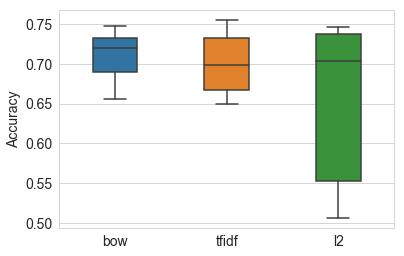

In [52]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

## Example 4-6. Final training and testing step to compare the different feature sets

In [53]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.7457091483681142
Test score with l2-normalized features: 0.7544815561488585
Test score with tf-idf features: 0.7524655369694327
